# Credit Decisor

## Setup

In [1]:
filename = 'photo.jpg'

In [2]:
%run helper.py

## Informações do Cliente

In [3]:
nome = "Lennon Alves Dias" #@param {type:"string"}
renda = 3000.00 #@param {type:"number"}
idade = 25 #@param {type:"slider", min:18, max:100, step:1}
etnia = 0  #@param {type:"number"}
genero = 0 #@param {type:"number"}
casa_propria = 1 #@param {type:"number"}
outras_rendas = 0 #@param {type:"number"}
estado_civil = 1 #@param {type:"number"}
escolaridade = 2 #@param {type:"number"}

In [4]:
person_client = {
  'nome': {'1': nome},
  'renda': {'1': renda},
  'idade': {'1': idade},
  'etnia': {'1': etnia},
  'sexo': {'1': genero},
  'casapropria': {'1': casa_propria},
  'outrasrendas': {'1': outras_rendas},
  'estadocivil': {'1': estado_civil},
  'escolaridade': {'1': escolaridade}
}

In [5]:
take_photo()

## Análise de Crédito

In [6]:
import json
import requests

In [7]:
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [8]:
authenticator = IAMAuthenticator(IBM_WATSON_API_KEY)
visual_recognition = VisualRecognitionV3(version="2020-04-29", authenticator=authenticator)
visual_recognition.set_service_url(IBM_WATSON_URL)

In [9]:
from azure.cognitiveservices.vision.face import FaceClient, models
from msrest.authentication import CognitiveServicesCredentials

In [10]:
face_client = FaceClient(AZURE_URL, CognitiveServicesCredentials(AZURE_API_KEY))

In [11]:
def validate_person(image):
  general_data = visual_recognition.classify(images_file=image, threshold=0.6, classifier_ids='default').get_result()
  general_classes = general_data['images'][0]['classifiers'][0]['classes']
  is_person = any(x['class'] == "person" for x in general_classes)
  return True if is_person else False

In [12]:
def validate_explicit(image):
  explicit_data = visual_recognition.classify(images_file=image, threshold=0.75, classifier_ids='explicit').get_result()
  explicit_classes = explicit_data['images'][0]['classifiers'][0]['classes']
  is_explicit = any(x['class'] == "explicit" for x in explicit_classes)
  return True if is_explicit else False

In [13]:
def facial_recognition(image):
    recognition = face_client.face.detect_with_stream(image=image, return_face_landmarks=True, return_face_attributes=["age", "gender"])
    face = recognition[0]
    print_fiducial_points(image, face)
    face_attributes = face.face_attributes
    return face_attributes.age, face_attributes.gender

In [14]:
PREDICT_URL = 'https://creditdecisor.lennon.cloud'
PREDICT_HEADERS = {'Content-Type': 'application/json'}

In [15]:
def predict_model(num, client):
    response = requests.request("POST", f'{PREDICT_URL}/modelo{num}', headers=PREDICT_HEADERS, json=client, verify=False)
    return response.json()

In [16]:
def identify_face(image):
    classifier = cv2.CascadeClassifier('classifiers/haarcascade_frontalface_default.xml')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = classifier.detectMultiScale(image_gray, 1.3, 5)
    if faces is None:
        cv2.putText(image, "Rosto ausente", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
    for (x,y,w,h) in faces:
        cv2.rectangle(image, (x,y), (x+w,y+h), (127,0,255), 2)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Face(s) identificadas")
    return faces is not None

In [17]:
def get_fiduncial_points(image):
    classifier_68_path = "models/shape_predictor_68_face_landmarks.dat"
    classifier = dlib.shape_predictor(classifier_68_path)
    detector = dlib.get_frontal_face_detector()
    rectangles = detector(image, 1)
    if len(rectangles) == 0:
        return None
    points = []
    for rectangle in rectangles:
        points.append(np.matrix([[p.x, p.y] for p in classifier(image, rectangle).parts()]))
    return points

In [18]:
def identify_fiduncial_points(image):
    points = get_fiduncial_points(image)
    image_points = draw_fiducial_points(image, points)
    image_points = cv2.cvtColor(image_points, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(image_points)
    plt.title("Pontos Fiduciais")

Credito concedido.


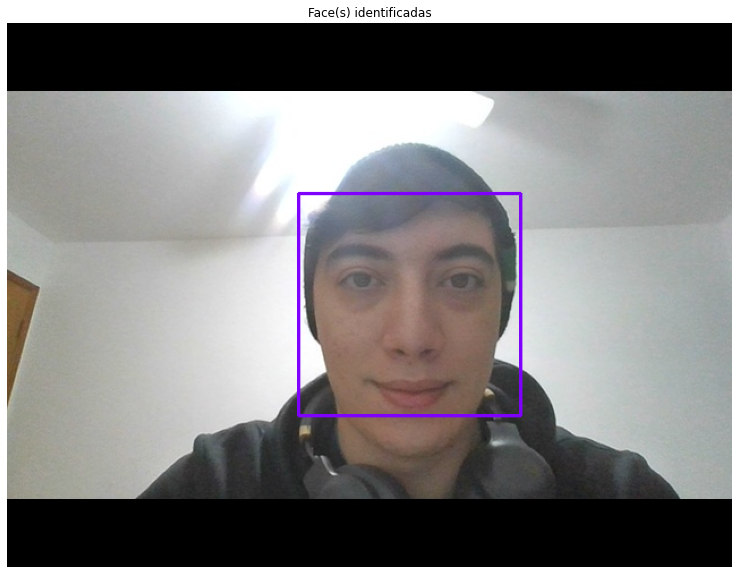

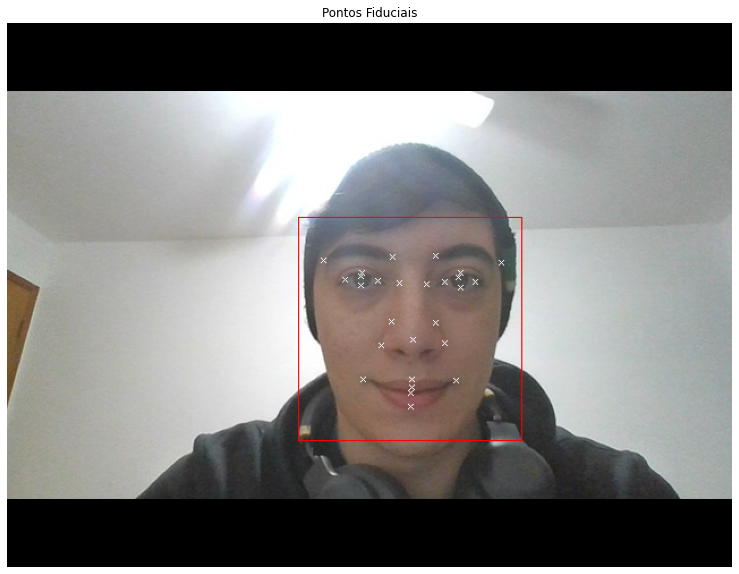

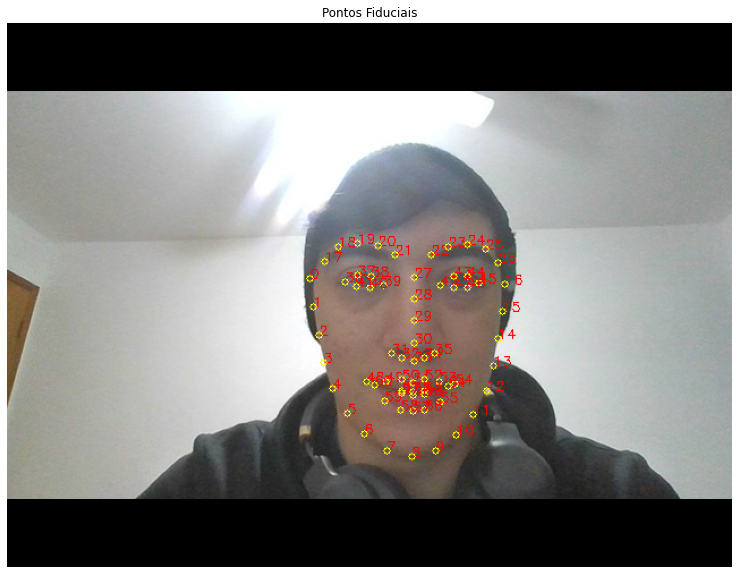

In [19]:
try:
  image = cv2.imread(filename)

  with open(filename, 'rb') as image_file:
    is_person = identify_face(image) and validate_person(image_file)
    if is_person == False:
      print('Credito negado. Motivo: Nao foi identificada uma pessoa na foto.')
      exit(0)

  with open(filename, 'rb') as image_file:
    is_explicit = validate_explicit(image_file)
    if is_explicit == True:
      print('Credito negado. Motivo: Imagem com conteudo inapropriado.')
      exit(0)

  with open(filename, 'rb') as image_file:
    (age, gender) = facial_recognition(image_file)
    age_diff = abs(person_client['idade']['1'] - age)
    if (age_diff > 5):
      print('Credito negado. Motivo: Idade nao comprovada.')
      exit(0)
    if ((person_client['sexo']['1'] == 0 and gender != models.Gender.male) or 
    (person_client['sexo']['1'] == 1 and gender != models.Gender.female)):
      print('Credito negado. Motivo: Genero nao comprovado.')
      exit(0)

  identify_fiduncial_points(image)

  score_01 = predict_model("01", person_client)
  score_02 = predict_model("02", person_client)
  
  if (score_01['prediction'][0] == 0 and score_02['prediction'][0] <= 0.7):
    print('Credito concedido.')
  else:
    print('Credito negado. Motivo: Score.')
except Exception as err:
  print(str(err))